# BitsxLaMarato | linies de la vida amb IA

In [6]:
import cv2
import fitz
from PIL import Image

## Image preprocessing / Loading the images

In [5]:
def extract_pages_as_images(pdf_path, output_folder):
    pdf_document = fitz.open(pdf_path)

    for page_num in range(pdf_document.page_count):
        page = pdf_document.load_page(page_num)
        image_list = page.get_pixmap(alpha=False)

        img_filename = f"{output_folder}/page{page_num + 1}.png"
        image_list.save(img_filename)

    pdf_document.close()

# List of PDF file names
pdf_files = ["RCTG_1.pdf", "RCTG_2.pdf", "RCTG_3.pdf", "RCTG_6.pdf", "RCTG_7_.pdf", "RCTG_8.pdf"]

# Folder to save extracted images
output_folder_path = "extracted_images"

# Iterate through each PDF file and extract images
for pdf_file in pdf_files:
    pdf_path = f"pdf_files/{pdf_file}"
    extract_pages_as_images(pdf_path, output_folder_path)

## Unlocking new patterns in FCF using OpenCV and Corner Detection

- Applying Shi-Tomasi Corner Detection to detect corners and potentially create new patterns for the FCF

C:\Users\musta\AppData\Local\Temp\ipykernel_4656\403003563.py:22: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


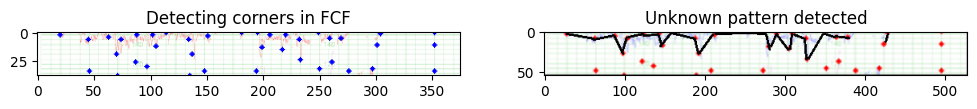

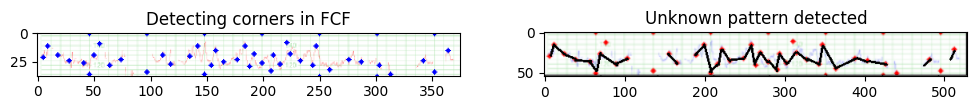

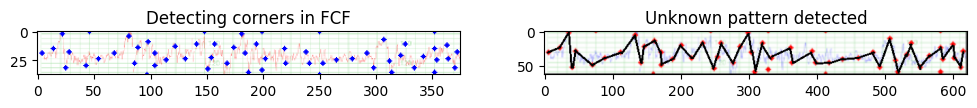

In [188]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

train_images = [cv2.imread("extracted_images/page1.png"), cv2.imread("extracted_images/page19.png"), cv2.imread("extracted_images/page59.png")]
processed_images = []  # List to store processed images

for i, page in enumerate(train_images):
    x, y, width, height = 50, 200, page.shape[1], page.shape[0] - 200 
    page = page[y:y+height, x:x+width]  # Crop the image to remove unwanted parts
    page = cv2.resize(page, (0, 0), fx=0.6, fy=0.6)  # Resize to 0.6 the original size
    x, y, width, height = 0, 0, page.shape[1], page.shape[0] - 130 
    page = page[y:y+height, x:x+width]  # Crop the image to remove unwanted parts

    # Convert to grayscale
    page_gray = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY)

    # Detect corners using cv2.goodFeaturesToTrack
    corners = cv2.goodFeaturesToTrack(page_gray, maxCorners=100, qualityLevel=0.01, minDistance=10)

    # Convert corners to integers
    corners = np.int0(corners)

    # Filter corners based on their quality (keep corners with high quality)
    filtered_corners = []
    for corner in corners:
        x, y = corner.ravel()
        if page_gray[y, x] > 150: # Keep corners with high quality but not too much because we want detail in the pattern
            filtered_corners.append((x, y))

    # Draw blue circles for filtered corners
    for corner in filtered_corners:
        x, y = corner
        cv2.circle(page, (x, y), 2, (255, 0, 0), -1)  # Draw blue circles for detected corners

    x, y, width, height = 0, 32, page.shape[1]-100, page.shape[0] - 70 
    processed_image = page[y:y+height, x:x+width]  # Crop the image to remove unwanted parts
    processed_images.append(processed_image)  # Store processed image

# Display the images with detected corners and the corresponding new patterns
for i, processed_image in enumerate(processed_images):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title("Detecting corners in FCF")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.imread(f"new_patterns/pattern{i+1}.png"))  # Access patterns using i+1 for correct indexing
    plt.title("Unknown pattern detected")
    plt.show()

> These new patterns are created by joining every corner and they are an aproximation as they take some maxima and minima, in real life the results will look a lot more noisier as this is a simple representation

Some points have been excluded because before we set a threshold to keep high quality features. While the threshold might be enough to capture most of the details in the FCF we have some unwanted noise.

## Apply pattern matching given some templates

- Load up all templates

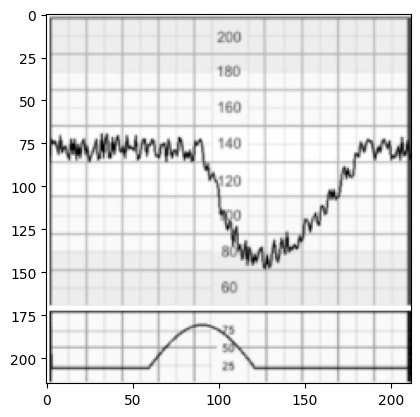

In [226]:
# Load the templates in grayscale
template_1 = cv2.imread("templates/template_1_deceleration.png",0)

template_2 = cv2.imread("templates/template_2_deceleration.png", 0)

template_3 = cv2.imread("templates/template_3_bradycardia.png", 0)

template_4 = cv2.imread("templates/template_4_reduced_variability.png", 0)

template_5 = cv2.imread("templates/template_5_skipper.png", 0)

template_6 = cv2.imread("templates/template_6_sinus.png", 0)

template_7 = cv2.imread("templates/template_7_pseudosinus.png", 0)

template_8 = cv2.imread("templates/template_8_acceleration.png", 0)

template_9 = cv2.imread("templates/template_9_early_decelerations.png", 0)

template_10 = cv2.imread("templates/template_10_variable_decelerations.png", 0)

template_11 = cv2.imread("templates/template_11_bradycardia_decelerations.png", 0)

template_12 = cv2.imread("templates/template_12_increaseFCFb.png", 0)

template_13 = cv2.imread("templates/template_13_reduced_variability.png", 0)

template_14 = cv2.imread("templates/template_14_terminal_cardiac_arrest.png", 0)

plt.imshow(template_2, cmap="gray")


Sample 1 matches Template 8 with SSIM score: 0.8438
Sample 2 matches Template 8 with SSIM score: 0.8298
Sample 3 matches Template 8 with SSIM score: 0.8445
Sample 4 matches Template 8 with SSIM score: 0.8283
Sample 5 matches Template 8 with SSIM score: 0.8445
Sample 6 matches Template 14 with SSIM score: 0.8530


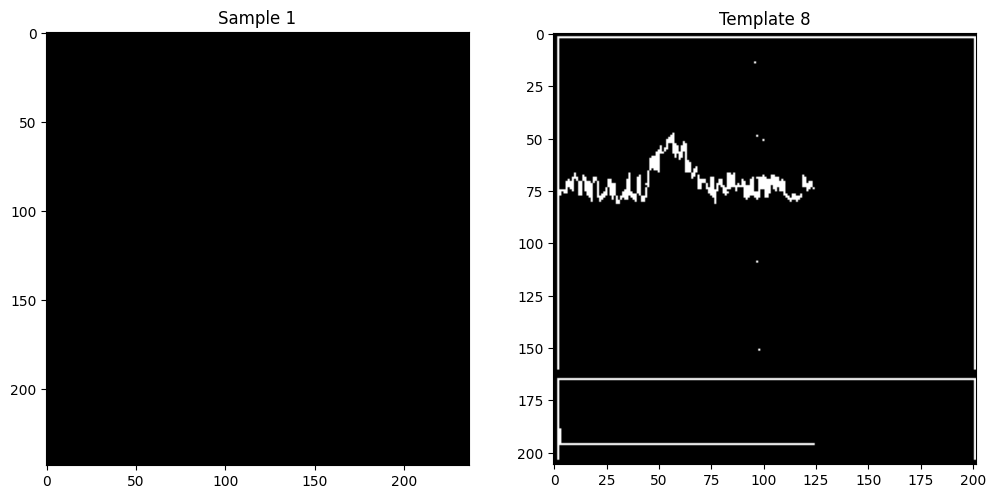

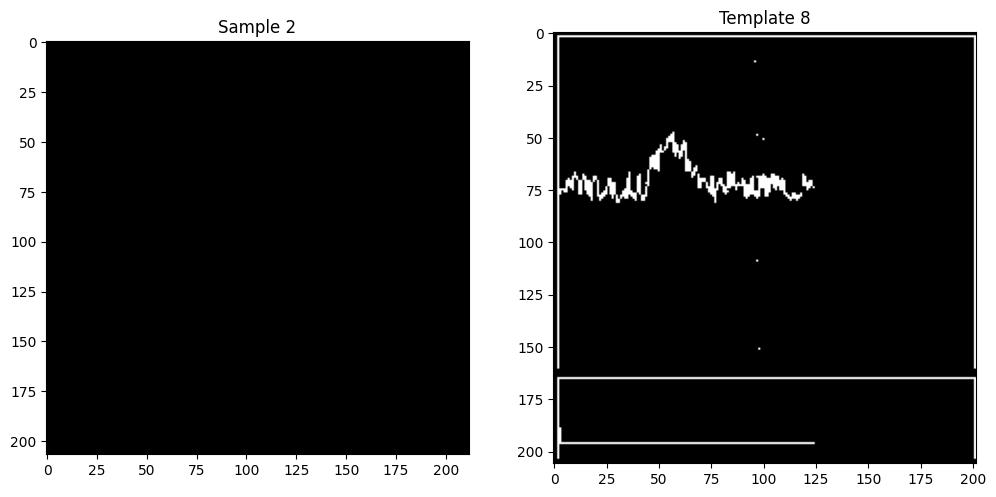

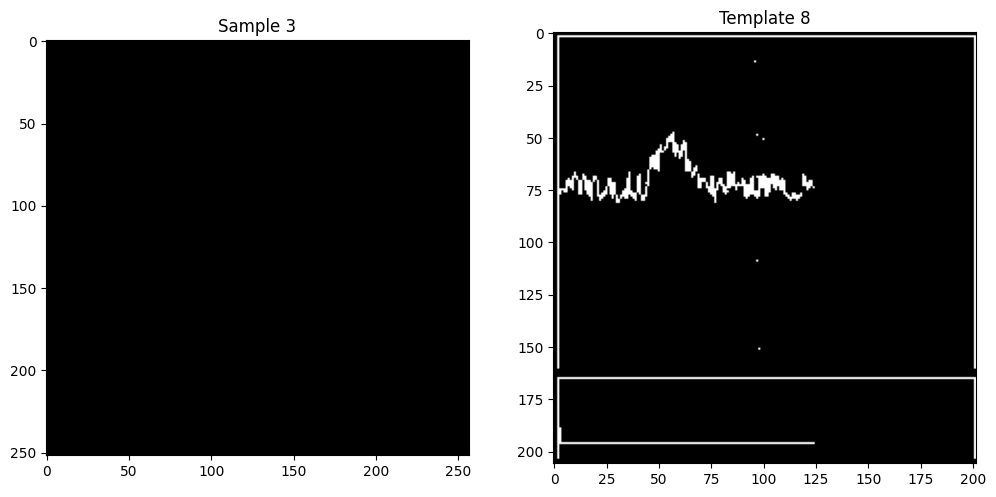

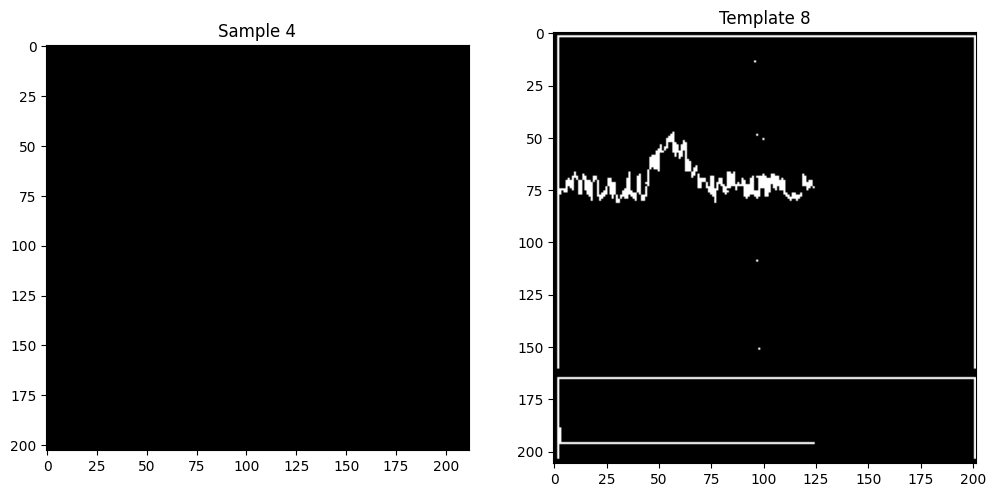

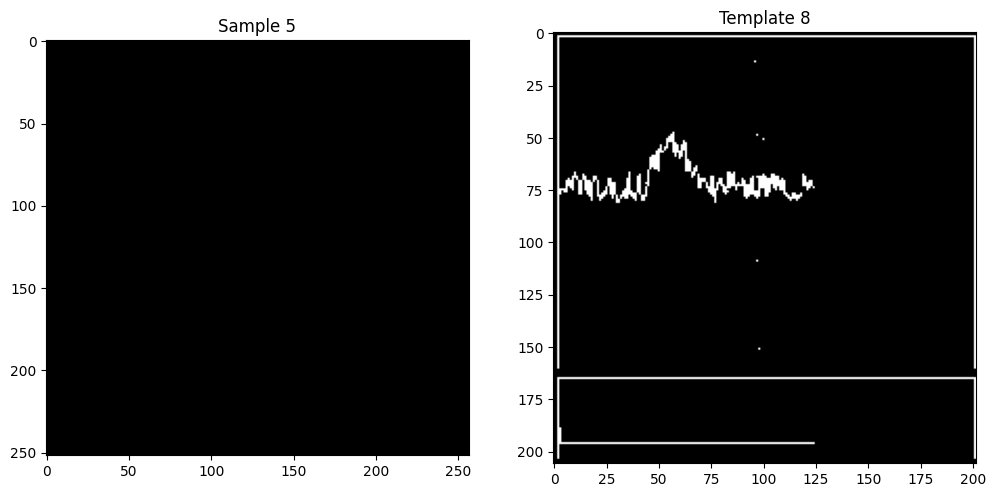

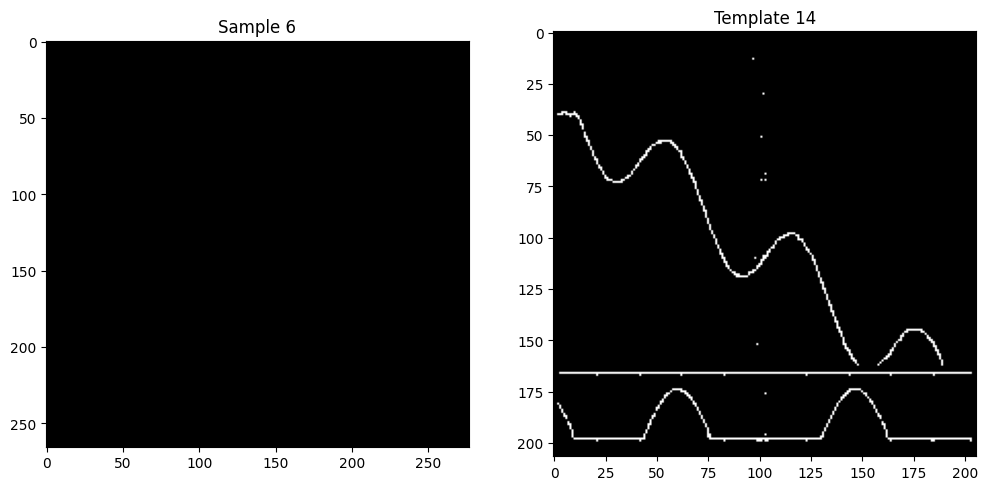

In [238]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Store the templates in a list
templates = [template_1, template_2, template_3, template_4, template_5, template_6, template_7, template_8, template_9, template_10, template_11, template_12, template_13, template_14]

# Load the samples (in grayscale) to which the templates will be matched with IoU
samples = [cv2.imread(f"samples/s{i+1}.png", 0) for i in range(6)]

# Binary threshold the samples and templates
binary_samples = [cv2.threshold(sample, 127, 255, cv2.THRESH_BINARY_INV)[1] for sample in samples]
binary_templates = [cv2.threshold(template, 127, 255, cv2.THRESH_BINARY_INV)[1] for template in templates]

SSIM_scores = []  # List to store SSIM scores
max_SSIM_indices = []  # List to store indices of max SSIM scores

# Compute SSIM between the samples and the templates
for sample_index, sample in enumerate(binary_samples):
    ssim_scores_for_sample = []
    for template_index, template in enumerate(binary_templates):
        # Resize the template to match the sample's dimensions
        resized_template = cv2.resize(template, (sample.shape[1], sample.shape[0]))
        ssim_score, _ = ssim(sample, resized_template, full=True)
        ssim_scores_for_sample.append(ssim_score)
    SSIM_scores.append(ssim_scores_for_sample)
    max_SSIM_indices.append((sample_index, np.argmax(ssim_scores_for_sample)))

# Convert SSIM scores to a numpy array
SSIM_scores = np.array(SSIM_scores)

# Get the maximum SSIM score for each sample
max_SSIM_scores = np.max(SSIM_scores, axis=1)

# Print the maximum SSIM scores and corresponding indices
for index, score in enumerate(max_SSIM_scores):
    sample_index, template_index = max_SSIM_indices[index]
    print(f"Sample {sample_index + 1} matches Template {template_index + 1} with SSIM score: {score:.4f}")

# Plot the samples and the corresponding templates
for sample_index, template_index in max_SSIM_indices:
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(binary_samples[sample_index], cmap="gray")
    plt.title(f"Sample {sample_index + 1}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(binary_templates[template_index], cmap="gray")
    plt.title(f"Template {template_index + 1}")
    plt.show()